In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import copy
import seaborn as sns
from sklearn.neighbors import KernelDensity
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
import warnings
%matplotlib inline

In [2]:
# PHASE = 'Summer'
PHASE = 'Winter'

lifetime_bounds = [2,80]
region = 'tropics'

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.7
ocean_frac_thresh = 0.1

if PHASE == 'Summer':
    track_period = '20160810_20160910'
    datetime_range = pd.to_datetime(['2016-08-10T00', '2016-09-11T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-15, 30]
if PHASE == 'Winter':
    track_period = '20200201_20200301'
    datetime_range = pd.to_datetime(['2020-02-01T00', '2020-03-01T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-20, 15]

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/'
dir_PyFLEXTRKR = f'{rootdir}PyFLEXTRKR/'
dir_MOAAP = f'{rootdir}MOAAP/'
dir_TOOCAN = f'{rootdir}TOOCAN/'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        # 'm8': 'ICON',
    }

if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        # 'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'GRIST',
        'm8': 'SCREAM',
        'm9': 'XSHiELD',
        'm10': 'GEOS',
        'm11': 'ICON',
    }

# Input filenames
filenames_PyFLEXTRKR = {key:f'{dir_PyFLEXTRKR}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_MOAAP = {key:f'{dir_MOAAP}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_TOOCAN = {key:f'{dir_TOOCAN}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/MCSMIP/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/


## Check if input files exist

In [3]:
for key, value in filenames_PyFLEXTRKR.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_stats_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_stats_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_stats_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_stats_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_stats_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_stats_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_stats_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_stats_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_stats_Winter_XSHiELD.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_stats_Winter_GEOS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_stats_Winter_ICON.nc: True


In [4]:
for key, value in filenames_MOAAP.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_stats_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_stats_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_stats_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_stats_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_stats_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_stats_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_stats_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_stats_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_stats_Winter_XSHiELD.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_stats_Winter_GEOS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_stats_Winter_ICON.nc: True


In [5]:
for key, value in filenames_TOOCAN.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_stats_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_stats_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_stats_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_stats_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_stats_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_stats_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_stats_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_stats_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_stats_Winter_XSHiELD.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_stats_Winter_GEOS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_stats_Winter_ICON.nc: True


## Show a map for the subset region

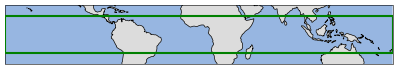

In [6]:
resolution = '110m'
# map_extent = [lon_bounds[0]-10,lon_bounds[1]+10,lat_bounds[0]-10,lat_bounds[1]+10]
map_extent = [lon_bounds[0],lon_bounds[1]-0.1,lat_bounds[0]-10,lat_bounds[1]+10]
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
proj = ccrs.PlateCarree(central_longitude=0)
box_proj = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=[10,10], dpi=50)
ax = plt.subplot(111, projection=proj)
ax.set_extent(map_extent, box_proj)
# Add land, coastlines, borders to inset
ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
# ax.add_feature(borders, edgecolor='k', facecolor='none')
# ax.add_feature(states, edgecolor='k', facecolor='none')
# Define the vertices of the rectangle in the projection coordinates
x1, y1 = proj.transform_point(lon_bounds[0], lat_bounds[0], proj)
x2, y2 = proj.transform_point(lon_bounds[1], lat_bounds[1], proj)
# Plot rectangle
ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=3, edgecolor='g', zorder=10))

In [7]:
# Read all files and combine them with a new dimension 'source'
ds_pyflex = xr.open_mfdataset(list(filenames_PyFLEXTRKR.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
ds_pyflex['source'] = list(name_map.keys())
ds_pyflex

<xarray.Dataset>
Dimensions:                  (tracks: 4941, times: 600, nmaxpf: 3, source: 11)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 4937 4938 4939 4940
  * times                    (times) int64 0 1 2 3 4 5 ... 595 596 597 598 599
  * nmaxpf                   (nmaxpf) int64 0 1 2
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm9' 'm10' 'm11'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 4941), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4941), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4941), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 4941, 600), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4941, 600), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4941, 600), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 4941, 600, 3), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 4941, 600, 3), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 4941, 600), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 4941, 600), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 4941, 600), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 4941, 600), meta=np.ndarray>
Attributes:
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Fri Oct 27 14:09:44 2023

In [8]:
# Read all files and combine them with a new dimension 'source'
ds_moaap = xr.open_mfdataset(list(filenames_MOAAP.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
ds_moaap['source'] = list(name_map.keys())
ds_moaap

<xarray.Dataset>
Dimensions:                  (tracks: 5320, times: 600, nmaxpf: 3, source: 11)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 5316 5317 5318 5319
  * times                    (times) int64 0 1 2 3 4 5 ... 595 596 597 598 599
  * nmaxpf                   (nmaxpf) int64 0 1 2
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm9' 'm10' 'm11'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 5320), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5320), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5320), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 5320, 600), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5320, 600), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5320, 600), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 5320, 600, 3), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 5320, 600, 3), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 5320, 600), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 5320, 600), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 5320, 600), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 5320, 600), meta=np.ndarray>
Attributes:
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Thu Oct 26 22:26:04 2023

In [9]:
# Read all files and combine them with a new dimension 'source'
ds_toocan = xr.open_mfdataset(list(filenames_TOOCAN.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
ds_toocan['source'] = list(name_map.keys())
ds_toocan

<xarray.Dataset>
Dimensions:                  (tracks: 44417, times: 600, nmaxpf: 3, source: 11)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 761760 762365 764644
  * times                    (times) int64 0 1 2 3 4 5 ... 595 596 597 598 599
  * nmaxpf                   (nmaxpf) int64 0 1 2
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm9' 'm10' 'm11'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 44417), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 44417), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 44417), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 44417, 600), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 44417, 600), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 44417, 600), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 44417, 600, 3), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 44417, 600, 3), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 44417, 600), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 44417, 600), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 44417, 600), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 44417, 600), meta=np.ndarray>
Attributes:
    title:                  Winter OBS MCS statistics file
    tracker:                TOOCAN
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Fri Nov  3 16:28:49 2023

In [10]:
datetime_range, lon_bounds, lat_bounds, lifetime_bounds

(DatetimeIndex(['2020-02-01', '2020-03-01'], dtype='datetime64[ns]', freq=None),
 [-180, 180],
 [-20, 15],
 [2, 80])

In [11]:
ds_pyflex.attrs

{'pixel_radius_km': 10.0,
 'time_resolution_hour': 1.0,
 'tb_core_thresh': 225.0,
 'tb_cold_thresh': 241.0,
 'nmaxpf': 3,
 'PF_rainrate_thresh': 2.0,
 'heavy_rainrate_thresh': 10.0,
 'landfrac_thresh': array([ 0, 90]),
 'Created_on': 'Fri Oct 27 14:09:44 2023'}

In [12]:
# Get global attributes
pixel_radius = ds_pyflex.attrs['pixel_radius_km']
time_resolution = ds_pyflex.attrs['time_resolution_hour']

In [13]:
def find_tracks_start(ds_in):
    """
    Find tracks within a period, region and lifetime bounds.
    """
    # Get the track start time, location, lifetime
    start_basetime = ds_in.start_basetime
    start_lon = ds_in.meanlon.isel(times=0)
    start_lat = ds_in.meanlat.isel(times=0)
    lifetime = ds_in.track_duration * ds_in.attrs['time_resolution_hour']

    # Filter tracks that initiates within a time period, region and lifetime
    ds_out = ds_in.where(
        (start_basetime >= min(datetime_range)) & (start_basetime <= max(datetime_range)) & \
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds))
    )
    return ds_out

def get_land_ocean_ds(ds_in):
    """
    Separate land vs. ocean tracks in Datasets.
    """
    init_landfrac = ds_in.pf_landfrac.isel(times=slice(0,3)).mean(dim='times')
    avg_landfrac = ds_in.pf_landfrac.mean(dim='times')
    ds_l = ds_in.where(avg_landfrac > land_frac_thresh)
    ds_o = ds_in.where(avg_landfrac < ocean_frac_thresh)
    return (ds_l, ds_o)

## Filter tracks by time, region, lifetime

In [14]:
dss_pyflex = find_tracks_start(ds_pyflex)

In [15]:
dss_moaap = find_tracks_start(ds_moaap)

In [16]:
dss_toocan = find_tracks_start(ds_toocan)

In [17]:
print(f'Number of MCS (PyFLEXTRKR)')
for key in dss_pyflex['source'].data:
    ntracks = np.count_nonzero(dss_pyflex.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (PyFLEXTRKR)
OBS: 1758
ARPEGE: 1976
IFS: 2071
MPAS: 1325
SAM: 1893
UM: 1514
GRIST: 771
SCREAM: 1604
XSHiELD: 2376
GEOS: 1988
ICON: 2823


In [18]:
print(f'Number of MCS (MOAAP)')
for key in dss_moaap['source'].data:
    ntracks = np.count_nonzero(dss_moaap.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (MOAAP)
OBS: 1854
ARPEGE: 1041
IFS: 2246
MPAS: 1545
SAM: 571
UM: 1302
GRIST: 92
SCREAM: 343
XSHiELD: 1673
GEOS: 1034
ICON: 772


In [19]:
print(f'Number of MCS (TOOCAN)')
for key in dss_toocan['source'].data:
    ntracks = np.count_nonzero(dss_toocan.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (TOOCAN)
OBS: 2714
ARPEGE: 1665
IFS: 3987
MPAS: 2016
SAM: 1415
UM: 1891
GRIST: 333
SCREAM: 1564
XSHiELD: 2659
GEOS: 2329
ICON: 388


## Separate land vs. ocean MCS

In [20]:
dss_pyflex_l, dss_pyflex_o = get_land_ocean_ds(dss_pyflex)

In [21]:
dss_moaap_l, dss_moaap_o = get_land_ocean_ds(dss_moaap)

In [22]:
dss_toocan_l, dss_toocan_o = get_land_ocean_ds(dss_toocan)

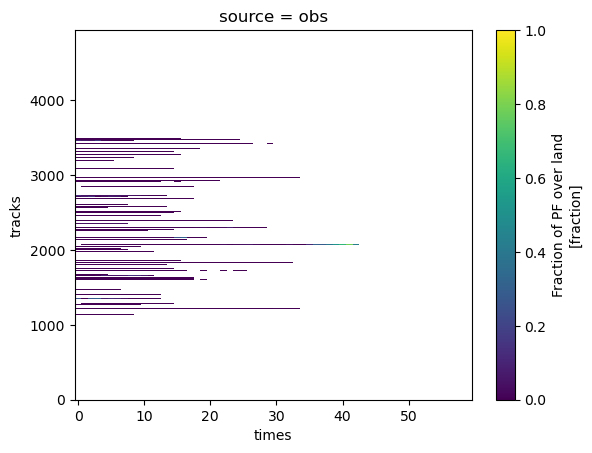

In [23]:
dss_pyflex_o.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

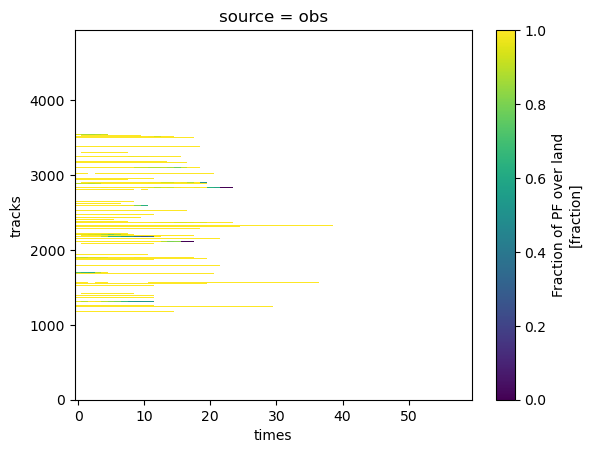

In [24]:
dss_pyflex_l.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

In [25]:
# TODO: use a simple method to separate possible merge/split tracks
# E.g., if max CCS area occur within the first 10% of a tracks start time: split; or within last 10% of a tracks end time: merge
# ds.ccs_area.max(dim='times')

In [26]:
def dataarray_to_dataframe(da, row_names=None, column_names=None):
    """
    Convert Xarray DataArray to Pandas DataFrame
    """
    # Convert to DataFrame
    df = pd.DataFrame(da.data)
    # Assign 'source' as column names
    if row_names:
        df.index = row_names
    if column_names:
        df.columns = column_names
        # df.columns = list(da['source'].data)
    return df

### CCS lifetime

In [27]:
da_tmp = (dss_pyflex_l.track_duration * dss_pyflex_l.attrs['time_resolution_hour']).transpose()
ccslifetime_pyflex_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_pyflex_o.track_duration * dss_pyflex_o.attrs['time_resolution_hour']).transpose()
ccslifetime_pyflex_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [28]:
da_tmp = (dss_moaap_l.track_duration * dss_moaap_l.attrs['time_resolution_hour']).transpose()
ccslifetime_moaap_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_moaap_o.track_duration * dss_moaap_o.attrs['time_resolution_hour']).transpose()
ccslifetime_moaap_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [29]:
da_tmp = (dss_toocan_l.track_duration * dss_toocan_l.attrs['time_resolution_hour']).transpose()
ccslifetime_toocan_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_toocan_o.track_duration * dss_toocan_o.attrs['time_resolution_hour']).transpose()
ccslifetime_toocan_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [30]:
ccslifetime_pyflex_o

,OBS,ARPEGE,IFS,MPAS,SAM,UM,GRIST,SCREAM,XSHiELD,GEOS,ICON
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
4939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0


(0.0, 80.0)

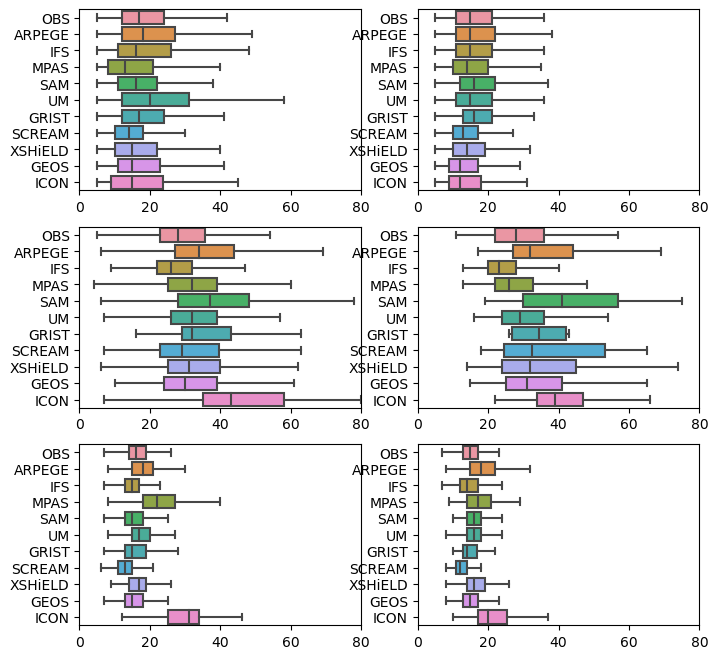

In [32]:
fig, axes = plt.subplots(3, 2, figsize=(8,8))
sns.boxplot(data=ccslifetime_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
sns.boxplot(data=ccslifetime_moaap_o,  orient='h', ax=axes[1][0], showfliers=False)
sns.boxplot(data=ccslifetime_toocan_o,  orient='h', ax=axes[2][0], showfliers=False)

sns.boxplot(data=ccslifetime_pyflex_l,  orient='h', ax=axes[0][1], showfliers=False)
sns.boxplot(data=ccslifetime_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
sns.boxplot(data=ccslifetime_toocan_l,  orient='h', ax=axes[2][1], showfliers=False)
axes[0][0].set_xlim(0,80)
axes[1][0].set_xlim(0,80)
axes[2][0].set_xlim(0,80)
axes[0][1].set_xlim(0,80)
axes[1][1].set_xlim(0,80)
axes[2][1].set_xlim(0,80)

### Max CCS area

In [33]:
da_tmp = (dss_pyflex_l.ccs_area.max(dim='times')).transpose()
maxccsarea_pyflex_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_pyflex_o.ccs_area.max(dim='times')).transpose()
maxccsarea_pyflex_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [34]:
da_tmp = (dss_moaap_l.ccs_area.max(dim='times')).transpose()
maxccsarea_moaap_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_moaap_o.ccs_area.max(dim='times')).transpose()
maxccsarea_moaap_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [35]:
da_tmp = (dss_toocan_l.ccs_area.max(dim='times')).transpose()
maxccsarea_toocan_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_toocan_o.ccs_area.max(dim='times')).transpose()
maxccsarea_toocan_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [36]:
# Convert to log10, and replace -inf with NaN
log10maxccsarea_pyflex_o = np.log10(maxccsarea_pyflex_o)
log10maxccsarea_pyflex_l = np.log10(maxccsarea_pyflex_l)
log10maxccsarea_pyflex_o.replace(-np.inf, np.nan, inplace=True)
log10maxccsarea_pyflex_l.replace(-np.inf, np.nan, inplace=True)

log10maxccsarea_moaap_o = np.log10(maxccsarea_moaap_o)
log10maxccsarea_moaap_l = np.log10(maxccsarea_moaap_l)
log10maxccsarea_moaap_o.replace(-np.inf, np.nan, inplace=True)
log10maxccsarea_moaap_l.replace(-np.inf, np.nan, inplace=True)

log10maxccsarea_toocan_o = np.log10(maxccsarea_toocan_o)
log10maxccsarea_toocan_l = np.log10(maxccsarea_toocan_l)
log10maxccsarea_toocan_o.replace(-np.inf, np.nan, inplace=True)
log10maxccsarea_toocan_l.replace(-np.inf, np.nan, inplace=True)

(4.5, 6.8)

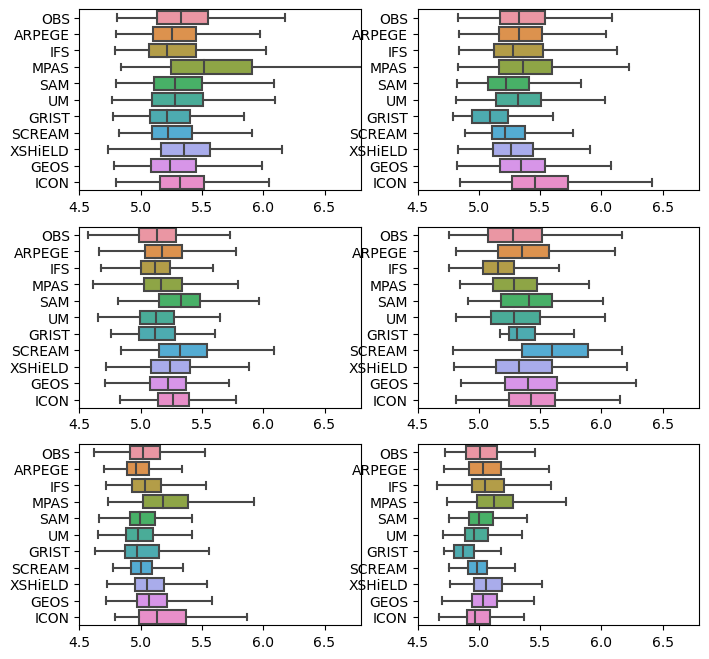

In [37]:
fig, axes = plt.subplots(3, 2, figsize=(8,8))
sns.boxplot(data=log10maxccsarea_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
sns.boxplot(data=log10maxccsarea_moaap_o,  orient='h', ax=axes[1][0], showfliers=False)
sns.boxplot(data=log10maxccsarea_toocan_o,  orient='h', ax=axes[2][0], showfliers=False)

sns.boxplot(data=log10maxccsarea_pyflex_l,  orient='h', ax=axes[0][1], showfliers=False)
sns.boxplot(data=log10maxccsarea_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
sns.boxplot(data=log10maxccsarea_toocan_l,  orient='h', ax=axes[2][1], showfliers=False)
axes[0][0].set_xlim(4.5,6.8)
axes[1][0].set_xlim(4.5,6.8)
axes[2][0].set_xlim(4.5,6.8)
axes[0][1].set_xlim(4.5,6.8)
axes[1][1].set_xlim(4.5,6.8)
axes[2][1].set_xlim(4.5,6.8)

In [38]:
# fig, axes = plt.subplots(2, 2, figsize=(8,8))
# sns.boxplot(data=maxccsarea_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
# sns.boxplot(data=maxccsarea_pyflex_l,  orient='h', ax=axes[1][0], showfliers=False)
# sns.boxplot(data=maxccsarea_moaap_o,  orient='h', ax=axes[0][1], showfliers=False)
# sns.boxplot(data=maxccsarea_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
# axes[0][0].set_xlim(4.5,6.8)
# axes[1][0].set_xlim(4.5,6.8)
# axes[0][1].set_xlim(4.5,6.8)
# axes[1][1].set_xlim(4.5,6.8)

### Lifetime-average min Tb

In [39]:
da_tmp = (dss_pyflex_l.corecold_mintb.mean(dim='times')).transpose()
avgmintb_pyflex_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_pyflex_o.corecold_mintb.mean(dim='times')).transpose()
avgmintb_pyflex_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [40]:
da_tmp = (dss_moaap_l.corecold_mintb.mean(dim='times')).transpose()
avgmintb_moaap_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_moaap_o.corecold_mintb.mean(dim='times')).transpose()
avgmintb_moaap_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [41]:
da_tmp = (dss_toocan_l.corecold_mintb.mean(dim='times')).transpose()
avgmintb_toocan_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_toocan_o.corecold_mintb.mean(dim='times')).transpose()
avgmintb_toocan_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

(180.0, 225.0)

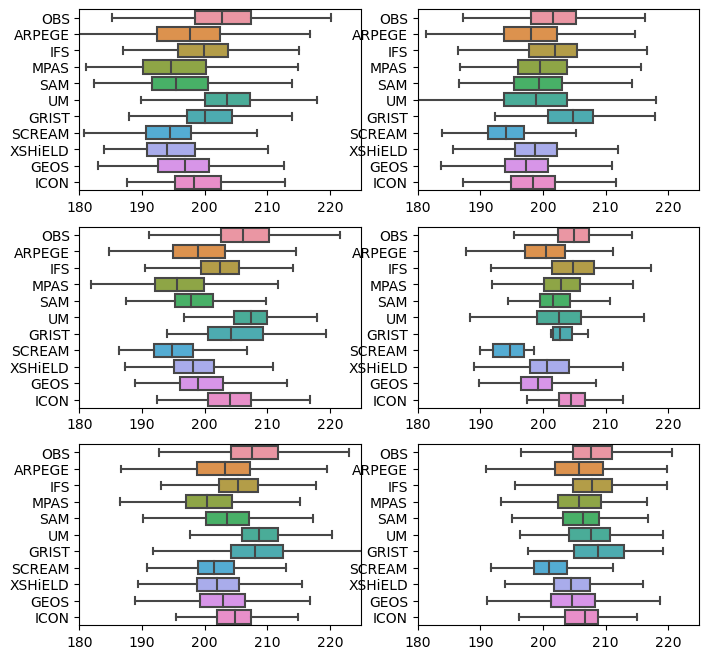

In [42]:
fig, axes = plt.subplots(3, 2, figsize=(8,8))
sns.boxplot(data=avgmintb_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
sns.boxplot(data=avgmintb_moaap_o,  orient='h', ax=axes[1][0], showfliers=False)
sns.boxplot(data=avgmintb_toocan_o,  orient='h', ax=axes[2][0], showfliers=False)

sns.boxplot(data=avgmintb_pyflex_l,  orient='h', ax=axes[0][1], showfliers=False)
sns.boxplot(data=avgmintb_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
sns.boxplot(data=avgmintb_toocan_l,  orient='h', ax=axes[2][1], showfliers=False)
axes[0][0].set_xlim(180,225)
axes[1][0].set_xlim(180,225)
axes[2][0].set_xlim(180,225)
axes[0][1].set_xlim(180,225)
axes[1][1].set_xlim(180,225)
axes[2][1].set_xlim(180,225)

In [43]:
# fig, axes = plt.subplots(2, 2, figsize=(8,8))
# sns.boxplot(data=avgmintb_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
# sns.boxplot(data=avgmintb_pyflex_l,  orient='h', ax=axes[1][0], showfliers=False)
# sns.boxplot(data=avgmintb_moaap_o,  orient='h', ax=axes[0][1], showfliers=False)
# sns.boxplot(data=avgmintb_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
# axes[0][0].set_xlim(180,225)
# axes[1][0].set_xlim(180,225)
# axes[0][1].set_xlim(180,225)
# axes[1][1].set_xlim(180,225)

### Total volume rain

In [44]:
# Suppress RuntimeWarning messages
warnings.filterwarnings("ignore", category=RuntimeWarning)

da_tmp = (dss_pyflex_l.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_pyflex_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_pyflex_o.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_pyflex_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [45]:
da_tmp = (dss_moaap_l.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_moaap_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_moaap_o.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_moaap_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [46]:
da_tmp = (dss_toocan_l.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_toocan_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_toocan_o.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_toocan_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [47]:
# Convert to log10, and replace -inf with NaN
log10pfvolrain_pyflex_o = np.log10(pfvolrain_pyflex_o)
log10pfvolrain_pyflex_l = np.log10(pfvolrain_pyflex_l)
log10pfvolrain_pyflex_o.replace(-np.inf, np.nan, inplace=True)
log10pfvolrain_pyflex_l.replace(-np.inf, np.nan, inplace=True)

log10pfvolrain_moaap_o = np.log10(pfvolrain_moaap_o)
log10pfvolrain_moaap_l = np.log10(pfvolrain_moaap_l)
log10pfvolrain_moaap_o.replace(-np.inf, np.nan, inplace=True)
log10pfvolrain_moaap_l.replace(-np.inf, np.nan, inplace=True)

log10pfvolrain_toocan_o = np.log10(pfvolrain_toocan_o)
log10pfvolrain_toocan_l = np.log10(pfvolrain_toocan_l)
log10pfvolrain_toocan_o.replace(-np.inf, np.nan, inplace=True)
log10pfvolrain_toocan_l.replace(-np.inf, np.nan, inplace=True)

(5.0, 8.0)

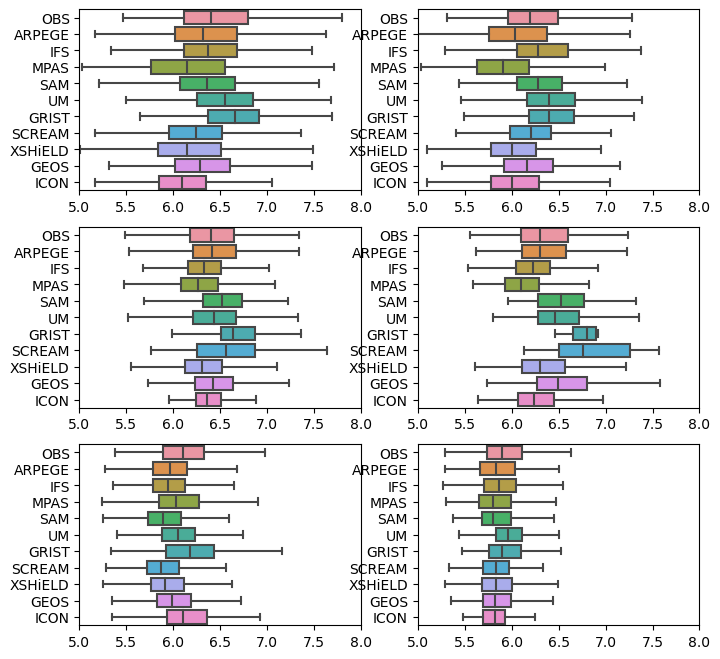

In [48]:
fig, axes = plt.subplots(3, 2, figsize=(8,8))
sns.boxplot(data=log10pfvolrain_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
sns.boxplot(data=log10pfvolrain_moaap_o,  orient='h', ax=axes[1][0], showfliers=False)
sns.boxplot(data=log10pfvolrain_toocan_o,  orient='h', ax=axes[2][0], showfliers=False)

sns.boxplot(data=log10pfvolrain_pyflex_l,  orient='h', ax=axes[0][1], showfliers=False)
sns.boxplot(data=log10pfvolrain_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
sns.boxplot(data=log10pfvolrain_toocan_l,  orient='h', ax=axes[2][1], showfliers=False)
axes[0][0].set_xlim(5,8)
axes[1][0].set_xlim(5,8)
axes[2][0].set_xlim(5,8)
axes[0][1].set_xlim(5,8)
axes[1][1].set_xlim(5,8)
axes[2][1].set_xlim(5,8)

In [49]:
# fig, axes = plt.subplots(2, 2, figsize=(8,8))
# sns.boxplot(data=log10pfvolrain_pyflex_o, orient='h', ax=axes[0][0], showfliers=False)
# sns.boxplot(data=log10pfvolrain_pyflex_l, orient='h', ax=axes[1][0], showfliers=False)
# sns.boxplot(data=log10pfvolrain_moaap_o, orient='h', ax=axes[0][1], showfliers=False)
# sns.boxplot(data=log10pfvolrain_moaap_l, orient='h', ax=axes[1][1], showfliers=False)
# axes[0][0].set_xlim(5,8)
# axes[1][0].set_xlim(5,8)
# axes[0][1].set_xlim(5,8)
# axes[1][1].set_xlim(5,8)

### Heavy rain volume

In [50]:
da_tmp = (dss_pyflex_l.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_pyflex_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_pyflex_o.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_pyflex_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [51]:
da_tmp = (dss_moaap_l.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_moaap_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_moaap_o.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_moaap_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [52]:
da_tmp = (dss_toocan_l.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_toocan_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_toocan_o.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_toocan_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [53]:
# # Convert to log10, and replace -inf with NaN
# log10pfheavyvolrain_pyflex_o = np.log10(pfheavyvolrain_pyflex_o)
# log10pfheavyvolrain_pyflex_l = np.log10(pfheavyvolrain_pyflex_l)
# pfheavyvolrain_pyflex_l.replace(-np.inf, np.nan, inplace=True)
# pfheavyvolrain_pyflex_o.replace(-np.inf, np.nan, inplace=True)

# log10pfheavyvolrain_moaap_o = np.log10(pfheavyvolrain_moaap_o)
# log10pfheavyvolrain_moaap_l = np.log10(pfheavyvolrain_moaap_l)
# pfheavyvolrain_moaap_l.replace(-np.inf, np.nan, inplace=True)
# pfheavyvolrain_moaap_o.replace(-np.inf, np.nan, inplace=True)

### Heavy rain volume ratio

In [54]:
pfhrr_pyflex_l = 100 * pfheavyvolrain_pyflex_l / pfvolrain_pyflex_l
pfhrr_pyflex_o = 100 * pfheavyvolrain_pyflex_o / pfvolrain_pyflex_o

pfhrr_moaap_l = 100 * pfheavyvolrain_moaap_l / pfvolrain_moaap_l
pfhrr_moaap_o = 100 * pfheavyvolrain_moaap_o / pfvolrain_moaap_o

pfhrr_toocan_l = 100 * pfheavyvolrain_toocan_l / pfvolrain_toocan_l
pfhrr_toocan_o = 100 * pfheavyvolrain_toocan_o / pfvolrain_toocan_o

In [55]:
# Convert to log10, and replace -inf with NaN
log10pfhrr_pyflex_o = np.log10(pfhrr_pyflex_o)
log10pfhrr_pyflex_l = np.log10(pfhrr_pyflex_l)
pfhrr_pyflex_l.replace(-np.inf, np.nan, inplace=True)
pfhrr_pyflex_o.replace(-np.inf, np.nan, inplace=True)

log10pfhrr_moaap_o = np.log10(pfhrr_moaap_o)
log10pfhrr_moaap_l = np.log10(pfhrr_moaap_l)
pfhrr_moaap_l.replace(-np.inf, np.nan, inplace=True)
pfhrr_moaap_o.replace(-np.inf, np.nan, inplace=True)

log10pfhrr_toocan_o = np.log10(pfhrr_toocan_o)
log10pfhrr_toocan_l = np.log10(pfhrr_toocan_l)
pfhrr_toocan_l.replace(-np.inf, np.nan, inplace=True)
pfhrr_toocan_o.replace(-np.inf, np.nan, inplace=True)

(0.0, 100.0)

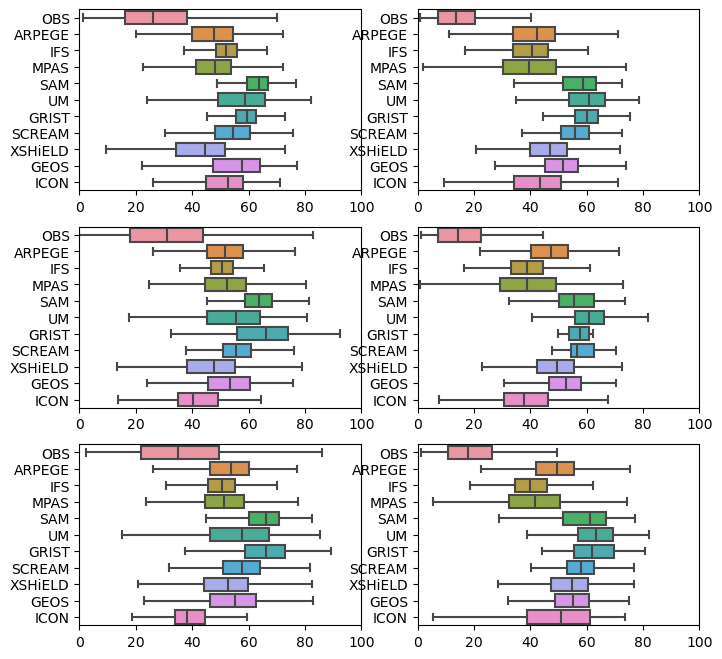

In [56]:
fig, axes = plt.subplots(3, 2, figsize=(8,8))
sns.boxplot(data=pfhrr_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
sns.boxplot(data=pfhrr_moaap_o,  orient='h', ax=axes[1][0], showfliers=False)
sns.boxplot(data=pfhrr_toocan_o,  orient='h', ax=axes[2][0], showfliers=False)

sns.boxplot(data=pfhrr_pyflex_l,  orient='h', ax=axes[0][1], showfliers=False)
sns.boxplot(data=pfhrr_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
sns.boxplot(data=pfhrr_toocan_l,  orient='h', ax=axes[2][1], showfliers=False)
axes[0][0].set_xlim(0,100)
axes[1][0].set_xlim(0,100)
axes[2][0].set_xlim(0,100)
axes[0][1].set_xlim(0,100)
axes[1][1].set_xlim(0,100)
axes[2][1].set_xlim(0,100)

In [57]:
# fig, axes = plt.subplots(2, 2, figsize=(8,8))
# sns.boxplot(data=pfhrr_pyflex_o, orient='h', ax=axes[0][0], showfliers=False)
# sns.boxplot(data=pfhrr_pyflex_l, orient='h', ax=axes[1][0], showfliers=False)
# sns.boxplot(data=pfhrr_moaap_o, orient='h', ax=axes[0][1], showfliers=False)
# sns.boxplot(data=pfhrr_moaap_l, orient='h', ax=axes[1][1], showfliers=False)
# axes[0][0].set_xlim(0,100)
# axes[1][0].set_xlim(0,100)
# axes[0][1].set_xlim(0,100)
# axes[1][1].set_xlim(0,100)

### Mean PF rain rate

In [58]:
da_tmp = (dss_pyflex_l.pf_rainrate.isel(nmaxpf=0).mean(dim='times')).transpose()
meanpfrainrate_pyflex_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_pyflex_o.pf_rainrate.isel(nmaxpf=0).mean(dim='times')).transpose()
meanpfrainrate_pyflex_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [59]:
da_tmp = (dss_moaap_l.pf_rainrate.isel(nmaxpf=0).mean(dim='times')).transpose()
meanpfrainrate_moaap_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_moaap_o.pf_rainrate.isel(nmaxpf=0).mean(dim='times')).transpose()
meanpfrainrate_moaap_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [60]:
da_tmp = (dss_toocan_l.pf_rainrate.isel(nmaxpf=0).mean(dim='times')).transpose()
meanpfrainrate_toocan_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_toocan_o.pf_rainrate.isel(nmaxpf=0).mean(dim='times')).transpose()
meanpfrainrate_toocan_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

(2.0, 20.0)

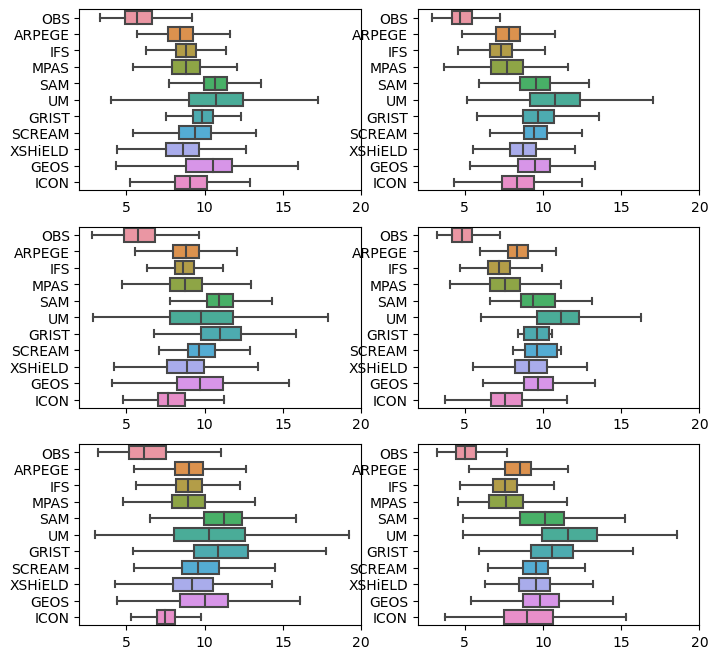

In [61]:
fig, axes = plt.subplots(3, 2, figsize=(8,8))
sns.boxplot(data=meanpfrainrate_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
sns.boxplot(data=meanpfrainrate_moaap_o,  orient='h', ax=axes[1][0], showfliers=False)
sns.boxplot(data=meanpfrainrate_toocan_o,  orient='h', ax=axes[2][0], showfliers=False)

sns.boxplot(data=meanpfrainrate_pyflex_l,  orient='h', ax=axes[0][1], showfliers=False)
sns.boxplot(data=meanpfrainrate_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
sns.boxplot(data=meanpfrainrate_toocan_l,  orient='h', ax=axes[2][1], showfliers=False)
axes[0][0].set_xlim(2,20)
axes[1][0].set_xlim(2,20)
axes[2][0].set_xlim(2,20)
axes[0][1].set_xlim(2,20)
axes[1][1].set_xlim(2,20)
axes[2][1].set_xlim(2,20)

In [62]:
# fig, axes = plt.subplots(2, 2, figsize=(8,8))
# sns.boxplot(data=meanpfrainrate_pyflex_o, orient='h', ax=axes[0][0], showfliers=False)
# sns.boxplot(data=meanpfrainrate_pyflex_l, orient='h', ax=axes[1][0], showfliers=False)
# sns.boxplot(data=meanpfrainrate_moaap_o, orient='h', ax=axes[0][1], showfliers=False)
# sns.boxplot(data=meanpfrainrate_moaap_l, orient='h', ax=axes[1][1], showfliers=False)
# axes[0][0].set_xlim(2,20)
# axes[1][0].set_xlim(2,20)
# axes[0][1].set_xlim(2,20)
# axes[1][1].set_xlim(2,20)

In [63]:
    # [ccslifetime_pyflex_o, maxccsarea_pyflex_o, avgmintb_pyflex_o, ],
    # [log10pfvolrain_pyflex_o, meanpfrainrate_pyflex_o, pfhrr_pyflex_o]

In [64]:
ccslifetime_pyflex_o.median(), ccslifetime_moaap_o.median()

(OBS        17.0
 ARPEGE     18.0
 IFS        16.0
 MPAS       13.0
 SAM        16.0
 UM         20.0
 GRIST      17.0
 SCREAM     14.0
 XSHiELD    15.0
 GEOS       15.0
 ICON       15.0
 dtype: float64,
 OBS        28.0
 ARPEGE     34.0
 IFS        26.0
 MPAS       32.0
 SAM        37.0
 UM         32.0
 GRIST      32.0
 SCREAM     29.0
 XSHiELD    31.0
 GEOS       30.0
 ICON       43.0
 dtype: float64)

In [65]:
# 100 * (ccslifetime_pyflex_o.median()[1:] - ccslifetime_pyflex_o.median()['OBS']) / ccslifetime_pyflex_o.median()['OBS']

In [66]:
# len(ccslifetime_pyflex_o.median())

In [67]:
def get_diffs_percent(arrays):
    """
    Calculate relative difference between models & obs
    """
    nrow = len(arrays)
    ncol = len(arrays[0])-1
    # Make output array
    arr_out = np.full((nrow,ncol), np.NaN, dtype=float)
    for row in range(nrow):
        arr = arrays[row]
        arr_out[row,:] = 100 * (arr[1:] - arr['OBS']) / arr['OBS']
    return arr_out

In [68]:
list(name_map.values())[1:]

['ARPEGE',
 'IFS',
 'MPAS',
 'SAM',
 'UM',
 'GRIST',
 'SCREAM',
 'XSHiELD',
 'GEOS',
 'ICON']

In [93]:
ylabels = ['O (PyFLEXTRKR)','O (MOAAP)','O (TOOCAN)','L (PyFLEXTRKR)','L (MOAAP)','L (TOOCAN)']
xlabels = list(name_map.values())[1:]

arrays = [ccslifetime_pyflex_o.median(), ccslifetime_moaap_o.median(), ccslifetime_toocan_o.median(),
         ccslifetime_pyflex_l.median(), ccslifetime_moaap_l.median(), ccslifetime_toocan_l.median()]
ccslifetime_diffpercent_med_all = get_diffs_percent(arrays)

In [94]:
arrays = [maxccsarea_pyflex_o.median(), maxccsarea_moaap_o.median(), maxccsarea_toocan_o.median(),
         maxccsarea_pyflex_l.median(), maxccsarea_moaap_l.median(), maxccsarea_toocan_l.median()]
maxccsarea_diffpercent_med_all = get_diffs_percent(arrays)

In [95]:
arrays = [avgmintb_pyflex_o.median(), avgmintb_moaap_o.median(), avgmintb_toocan_o.median(),
         avgmintb_pyflex_l.median(), avgmintb_moaap_l.median(), avgmintb_toocan_l.median()]
avgmintb_diffpercent_med_all = get_diffs_percent(arrays)

In [96]:
arrays = [pfvolrain_pyflex_o[pfvolrain_pyflex_o > 0].median(), pfvolrain_moaap_o[pfvolrain_moaap_o > 0].median(), pfvolrain_toocan_o[pfvolrain_toocan_o > 0].median(),
         pfvolrain_pyflex_l[pfvolrain_pyflex_l > 0].median(), pfvolrain_moaap_l[pfvolrain_moaap_l > 0].median(), pfvolrain_toocan_l[pfvolrain_toocan_l > 0].median()]
pfvolrain_diffpercent_med_all = get_diffs_percent(arrays)

In [97]:
arrays = [meanpfrainrate_pyflex_o.median(), meanpfrainrate_moaap_o.median(), meanpfrainrate_toocan_o.median(),
         meanpfrainrate_pyflex_l.median(), meanpfrainrate_moaap_l.median(), meanpfrainrate_toocan_l.median()]
meanpfrainrate_diffpercent_med_all = get_diffs_percent(arrays)

In [98]:
arrays = [pfhrr_pyflex_o.median(), pfhrr_moaap_o.median(), pfhrr_toocan_o.median(),
         pfhrr_pyflex_l.median(), pfhrr_moaap_l.median(), pfhrr_toocan_l.median()]
pfhrr_diffpercent_med_all = get_diffs_percent(arrays)

In [99]:
# (pfvolrain_pyflex_o > 0).median()
# type(pfvolrain_pyflex_o)
# pfvolrain_pyflex_o[pfvolrain_pyflex_o > 0].median()
# pfvolrain_diffpercent_med_all

In [100]:
# ccslifetime_diffpercent_med_all[0,:]
# 100 * (ccslifetime_toocan_l.median()[1:] - ccslifetime_toocan_l.median()['OBS']) / ccslifetime_toocan_l.median()['OBS']

In [101]:
# maxccsarea_pyflex_o.median()

In [102]:
# 100 * (maxccsarea_pyflex_o.median()[1:] - maxccsarea_pyflex_o.median()['OBS']) / maxccsarea_pyflex_o.median()['OBS']

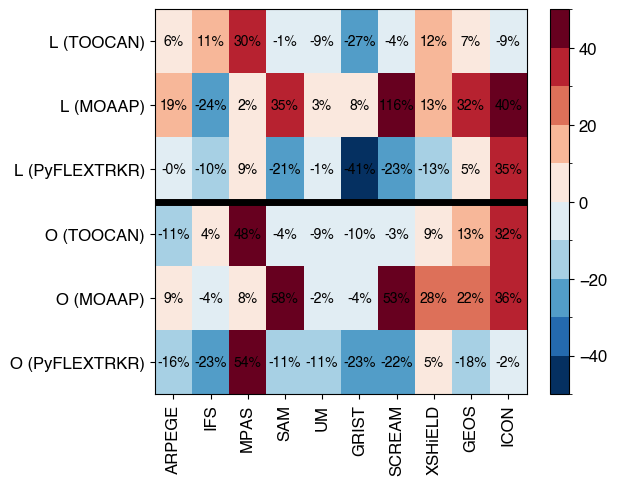

In [103]:
fig, ax = plt.subplots(1,1,figsize=[6,5], dpi=100)
levels = np.arange(-50, 51, 10)
cmap = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
# pcm = ax.pcolormesh(ccslifetime_diffpercent_med_all, norm=norm, cmap=cmap)
pcm = ax.pcolormesh(maxccsarea_diffpercent_med_all, norm=norm, cmap=cmap)

fig.colorbar(pcm)

# Axis labels
n_xlabels = len(xlabels)
n_ylabels = len(ylabels)
x_centers = np.arange(0.5, n_xlabels+0.5, 1)
y_centers = np.arange(0.5, n_ylabels+0.5, 1)
ax.set_xticks(x_centers, xlabels, rotation=90)
ax.set_yticks(y_centers, ylabels)

# Shade the background with colors
# Get x-axis limits
ymin, ymax = ax.get_ylim()
midpoint = (ymin + ymax) / 2
ax.axhline(y=midpoint, lw=5, color='k')

# Add text annotations at the center of each cell
for i, x in enumerate(x_centers):
    for j, y in enumerate(y_centers):
        # ax.annotate(f'{ccslifetime_diffpercent_med_all[j, i]:.0f}%', (x, y), color='k', fontsize=8, ha='center', va='center')
        ax.annotate(f'{maxccsarea_diffpercent_med_all[j, i]:.0f}%', (x, y), color='k', fontsize=10, ha='center', va='center')

## Function to plot mean difference on (m x n) panels

In [104]:
def shade_bias_mxn(nrow, ncol, data_arr, titles=None, xlabels=None, ylabels=None, show_xlabel=None, show_ylabel=None,
                   levels=None, cmap=None, cblabels=None, cbticks=None, cbshrink=1, label_topbot=None,
                   figsize=[10,10], fontsize=None):

    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=figsize, dpi=100)
    
    for row in range(0, nrow):
        for col in range(0, ncol): 
            ax = axes[row][col]
            data = data_arr[row][col]
            
            # Normalize color
            cmap = copy.copy(mpl.colormaps.get_cmap(cmap))
            norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
            pcm = ax.pcolormesh(data, norm=norm, cmap=cmap)
            ax.set_title(titles[row][col], loc='left')

            # Axis labels
            n_xlabels = len(xlabels)
            n_ylabels = len(ylabels)
            x_centers = np.arange(0.5, n_xlabels+0.5, 1)
            y_centers = np.arange(0.5, n_ylabels+0.5, 1)
            if show_xlabel[row][col]:
                ax.set_xticks(x_centers, xlabels, rotation=90)
            else:
                ax.set_xticks(x_centers, ['']*n_xlabels, rotation=90)
                # ax.set_x
            if show_ylabel[row][col]:
                ax.set_yticks(y_centers, ylabels)
            else:
                ax.set_yticks(y_centers, ['']*n_ylabels)
                
            # Label yaxis
            if (col == 0):
                ax.text(-0.45, 0.25, label_topbot[0], va='center', ha='center', rotation=90, weight='bold', fontsize=fontsize*1.5, transform=ax.transAxes)
                ax.text(-0.45, 0.75, label_topbot[1], va='center', ha='center', rotation=90, weight='bold', fontsize=fontsize*1.5, transform=ax.transAxes)

            # Shade the background with colors
            # Get x-axis limits
            ymin, ymax = ax.get_ylim()
            midpoint = (ymin + ymax) / 2
            ax.axhline(y=midpoint, lw=5, color='k')

            # Add text annotations at the center of each cell
            for i, x in enumerate(x_centers):
                for j, y in enumerate(y_centers):
                    ax.annotate(f'{data[j, i]:.0f}%', (x, y), color='k', fontsize=fontsize*0.8, ha='center', va='center')
                       
    fig.tight_layout(w_pad=0.6, h_pad=0.5)
    # Colorbar
    fig.colorbar(pcm, ax=axes[:,:], label=cblabels, ticks=cbticks, extend='both', pad=0.01, shrink=cbshrink)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

    return fig

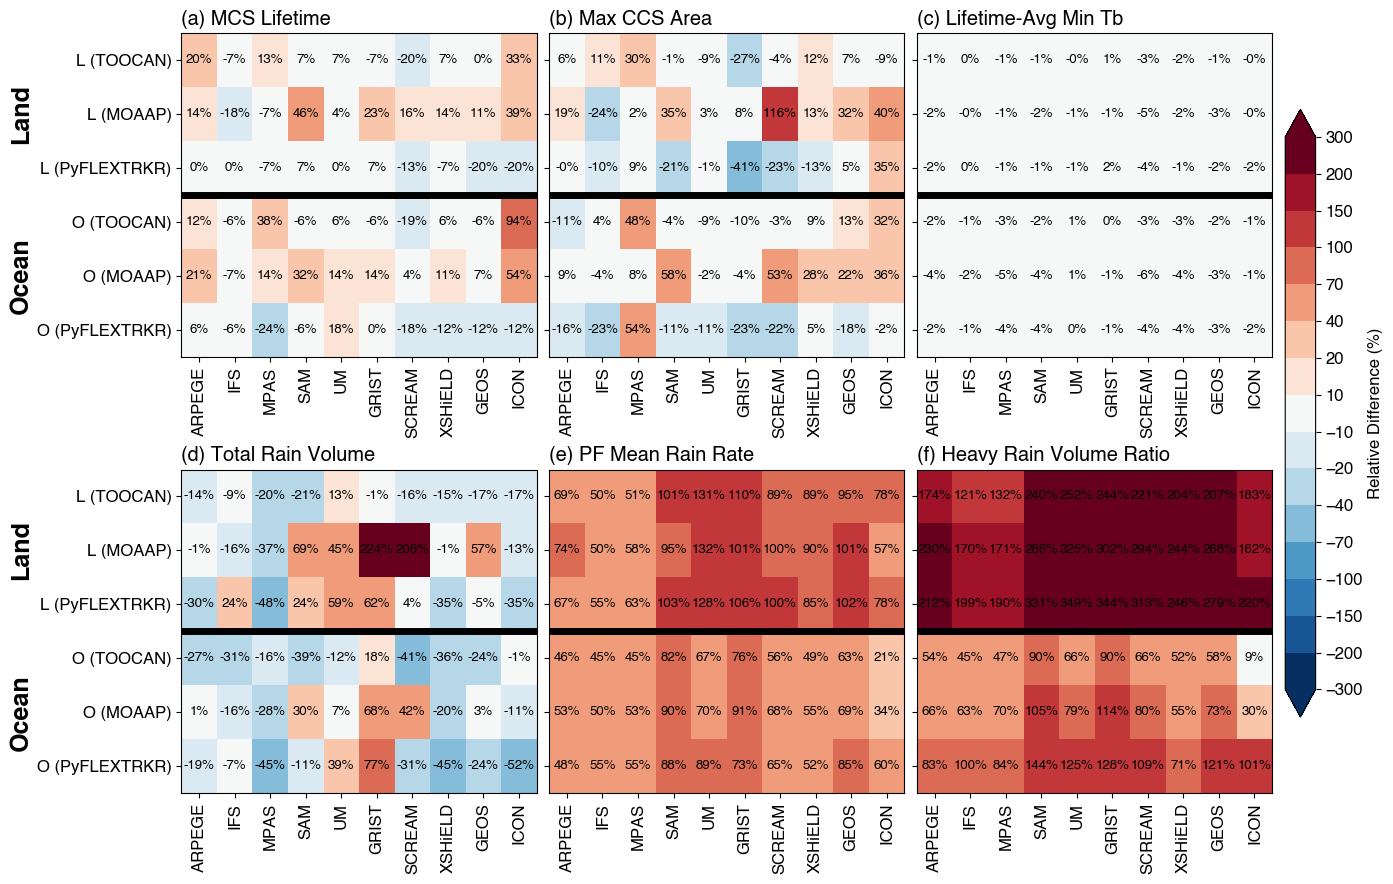

In [105]:
data_arr = [
    [ccslifetime_diffpercent_med_all, maxccsarea_diffpercent_med_all, avgmintb_diffpercent_med_all],
    [pfvolrain_diffpercent_med_all, meanpfrainrate_diffpercent_med_all, pfhrr_diffpercent_med_all]
]
titles = [
    ['(a) MCS Lifetime', '(b) Max CCS Area', '(c) Lifetime-Avg Min Tb'],
    ['(d) Total Rain Volume', '(e) PF Mean Rain Rate', '(f) Heavy Rain Volume Ratio'],
]
show_xlabel = [[True,True,True,],[True,True,True,]]
show_ylabel = [[True,False,False,],[True,False,False,]]
# levels = np.arange(-100, 101, 20)
levels = [-300,-200,-150,-100,-70,-40,-20,-10,10,20,40,70,100,150,200,300]
# levels = np.delete(levels, int((len(levels)-1)/2))
cbticks = levels
cblabels = 'Relative Difference (%)'
cmap = 'RdBu_r'
cbshrink = 0.8
label_topbot = ['Ocean', 'Land']
figsize = [15,9]
fontsize = 12
figname = f'{figdir}RelativeDiff_mcs_properties_2x3_median_all.png'
fig = shade_bias_mxn(2, 3, data_arr, titles=titles, xlabels=xlabels, ylabels=ylabels, show_xlabel=show_xlabel, show_ylabel=show_ylabel,
                   levels=levels, cmap=cmap, cbticks=cbticks, cblabels=cblabels, cbshrink=cbshrink, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

In [82]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/RelativeDiff_mcs_properties_2x3_median_all.png'

## Function to plot mirror box plot on (m x n) panels

In [83]:
def boxplot_mirror_mxn(nrow, ncol, data_top, data_bot, titles, xlabels, legends, figname,  
                        map_show=False, map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=[0,0], map_bottop='top', panel_colors=None,
                        legend_fontsize=11, legend_loc='best', label_topbot=None, legend_ncol=None, figsize=[10,10], fontsize=None):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(2,1, height_ratios=[1,1], width_ratios=[1])
    gs.update(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.15, hspace=0.3)
    # Use GridSpecFromSubplotSpec to setup top and bottom mirror panels
    gs_top = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[0], height_ratios=[0.5,0.5], width_ratios=[1,1,1,1], wspace=0.3, hspace=0)
    gs_bot = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[1], height_ratios=[0.5,0.5], width_ratios=[1,1,1,1], wspace=0.3, hspace=0)

    lcolors = {
        'obs': 'gray', 
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
    }
    lw = 1.5
    
    meanprops = {"marker": "o", "markerfacecolor": "r", "markeredgecolor": "k"}
    medianprops = {'linewidth': 3}
    barwidth = 0.5
    pcolors = list(lcolors.values())[:data_top[0][0].shape[1]]
    notch = False

    # Top row
    row = 0
    for col in range(0, ncol):
        # Top panel
        ax1 = plt.subplot(gs_top[0,col])
        sns.boxplot(data=data_top[row][col], orient='h', ax=ax1, palette=pcolors, showfliers=False, showmeans=True, width=barwidth, meanprops=meanprops, medianprops=medianprops, notch=notch)
        # Bottom mirror panel
        ax2 = plt.subplot(gs_top[1,col], sharex=ax1)
        ax2.invert_yaxis()
        # ax1.xaxis.set_ticklabels([])
        sns.boxplot(data=data_bot[row][col], orient='h', ax=ax2, palette=pcolors, showfliers=False, showmeans=True, width=barwidth, meanprops=meanprops, medianprops=medianprops, notch=notch)
        # Labels, gridlines, etc.
        ax1.grid(axis='x', ls='--')
        ax2.grid(axis='x', ls='--')
        ax1.set_title(titles[row][col], loc='left')
        ax2.set_xlabel(xlabels[row][col])
        ax1.tick_params(labelbottom=False)
        if panel_colors is not None:
            ax1.set_facecolor(panel_colors['top'])
            ax2.set_facecolor(panel_colors['bot'])
        # Label yaxis, legend
        if (col == 0):
            ax1.text(-0.35, 0.5, label_topbot[0], va='center', ha='center', rotation=90, weight='bold', transform=ax1.transAxes)
            ax2.text(-0.35, 0.5, label_topbot[1], va='center', ha='center', rotation=90, weight='bold', transform=ax2.transAxes)
            # ax1.legend(fontsize=legend_fontsize, loc=legend_loc, ncols=legend_ncol)


        # Plot inset map
        if (map_show):
            if (row == map_panel[0]) & (col == map_panel[1]):
                if map_bottop == 'top':
                    ax_map = ax1
                if map_bottop == 'bot':
                    ax_map = ax2
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                proj = ccrs.PlateCarree(central_longitude=0)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax_map, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(projection=proj))
                sub_ax.set_extent(map_extent, box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                # sub_ax.add_feature(borders, edgecolor=lcolors['obs'], facecolor='none', zorder=4)
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
                # Plot a box region in the inset
                box = sgeom.box(minx=lonbox[0], maxx=lonbox[1], miny=latbox[0], maxy=latbox[1])
                sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
                sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)
                
    # Bottom row
    row = 1
    for col in range(0, ncol): 
        # Top panel
        ax1 = plt.subplot(gs_bot[0,col])
        sns.boxplot(data=data_top[row][col], orient='h', ax=ax1, palette=pcolors, showfliers=False, showmeans=True, width=barwidth, meanprops=meanprops, medianprops=medianprops, notch=notch)
        # Bottom mirror panel
        ax2 = plt.subplot(gs_bot[1,col], sharex=ax1)
        ax2.invert_yaxis()
        sns.boxplot(data=data_bot[row][col], orient='h', ax=ax2, palette=pcolors, showfliers=False, showmeans=True, width=barwidth, meanprops=meanprops, medianprops=medianprops, notch=notch)
        # Labels, gridlines, etc.
        ax1.grid(axis='x', ls='--')
        ax2.grid(axis='x', ls='--')
        ax1.set_title(titles[row][col], loc='left')
        ax2.set_xlabel(xlabels[row][col])
        ax1.tick_params(labelbottom=False)
        if panel_colors is not None:
            ax1.set_facecolor(panel_colors['top'])
            ax2.set_facecolor(panel_colors['bot'])
        # Label yaxis, legend
        if (col == 0):
            ax1.text(-0.35, 0.5, label_topbot[0], va='center', ha='center', rotation=90, weight='bold', transform=ax1.transAxes)
            ax2.text(-0.35, 0.5, label_topbot[1], va='center', ha='center', rotation=90, weight='bold', transform=ax2.transAxes)
            
        fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

### Set up legends, inset map

In [84]:
# Inset map settings
map_extent = [lon_bounds[0],lon_bounds[1]-1,lat_bounds[0]-20,lat_bounds[1]+20]
lonbox = [lon_bounds[0], lon_bounds[1]-1]
latbox = [lat_bounds[0], lat_bounds[1]]
inset_param = {'width':'40%', 'height':'25%', 'loc':'upper right', 'borderpad':0.1}
map_extent, lonbox, latbox

([-180, 179, -40, 35], [-180, 179], [-20, 15])

## PyFLEXTRKR vs. MOAAP

In [85]:
# log10maxccsarea_pyflex_o

/tmp/ipykernel_1295742/913225336.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1295742/913225336.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1295742/913225336.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1295742/913225336.py:94: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykern

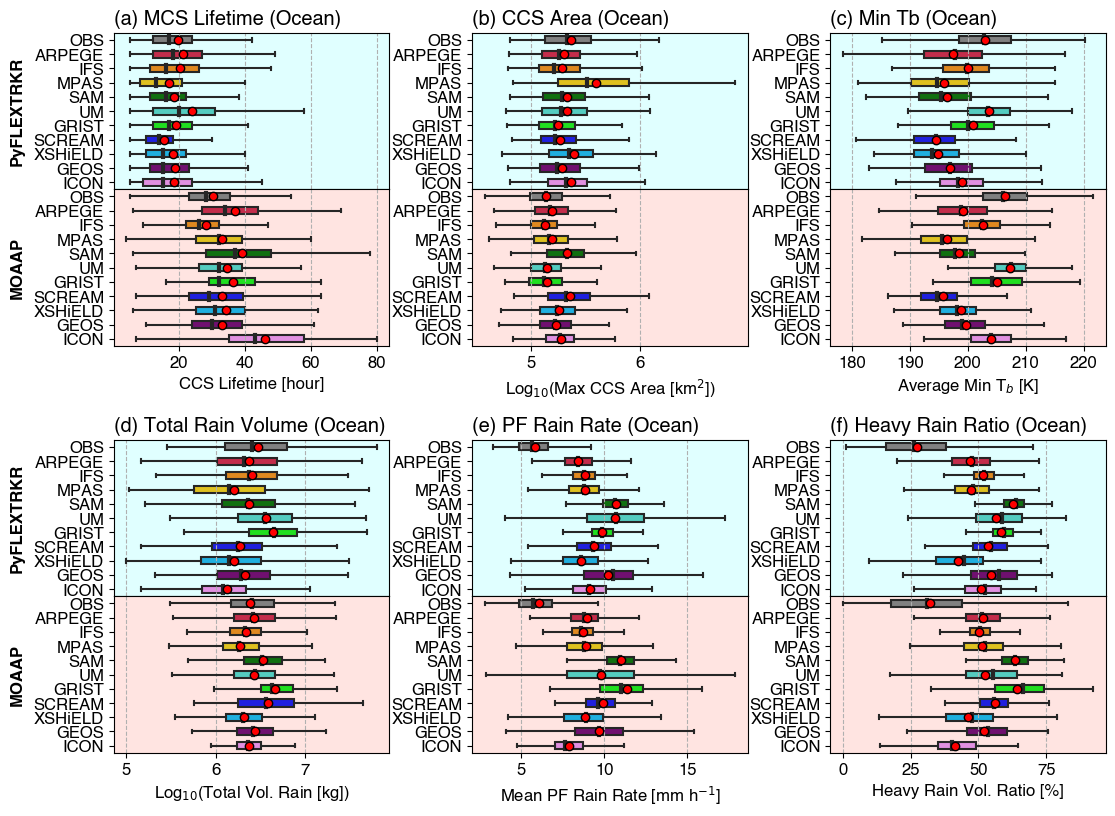

In [86]:
data_top = [
    [ccslifetime_pyflex_o, log10maxccsarea_pyflex_o, avgmintb_pyflex_o, ],
    [log10pfvolrain_pyflex_o, meanpfrainrate_pyflex_o, pfhrr_pyflex_o],
]
data_bot = [
    [ccslifetime_moaap_o, log10maxccsarea_moaap_o, avgmintb_moaap_o, ],
    [log10pfvolrain_moaap_o, meanpfrainrate_moaap_o, pfhrr_moaap_o],
]
titles = [
    ['(a) MCS Lifetime (Ocean)', '(b) CCS Area (Ocean)', '(c) Min Tb (Ocean)'],
    ['(d) Total Rain Volume (Ocean)', '(e) PF Rain Rate (Ocean)', '(f) Heavy Rain Ratio (Ocean)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Average Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'MOAAP']
panel_colors = {'top':'lightcyan', 'bot':'mistyrose'}
legend_ncol = 2
figsize = [15,9]
fontsize = 12
figname = f'{figdir}boxwhisker_mcs_ocean_2x3_PyFLEXTRKR_MOAAP.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

/tmp/ipykernel_1295742/913225336.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1295742/913225336.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1295742/913225336.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1295742/913225336.py:94: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykern

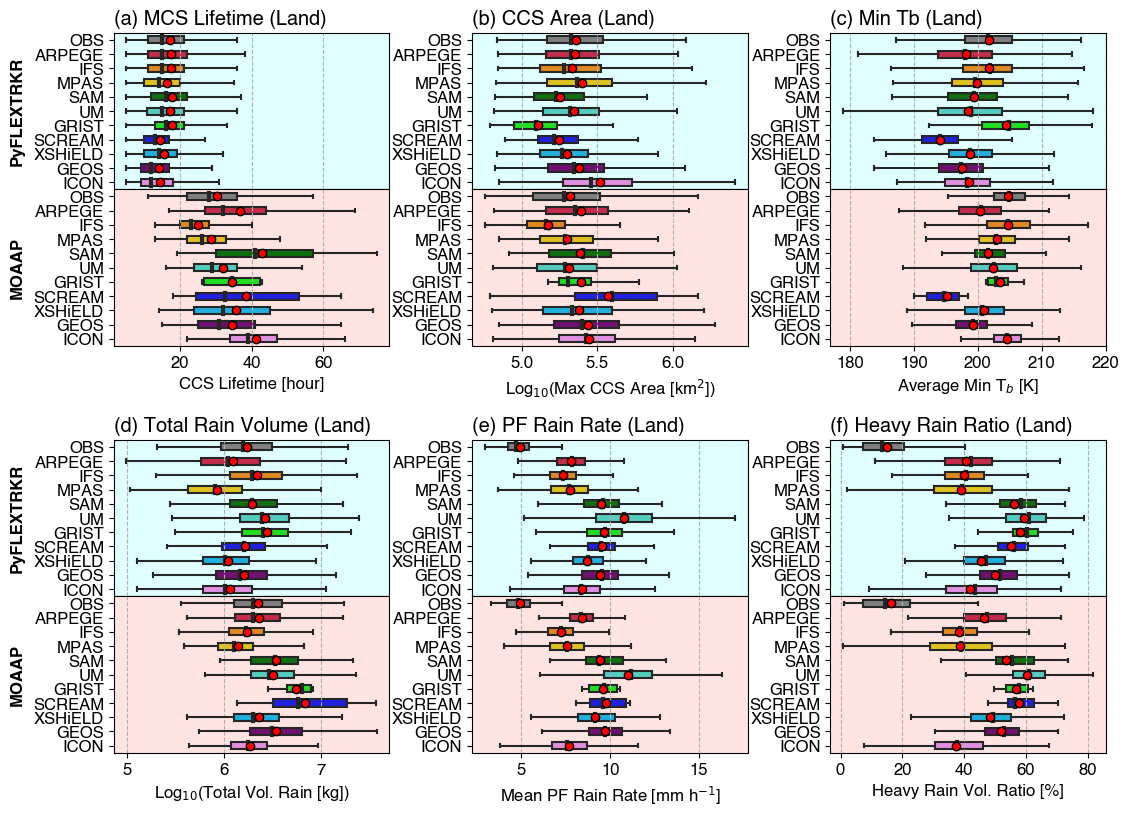

In [87]:
data_top = [
    [ccslifetime_pyflex_l, log10maxccsarea_pyflex_l, avgmintb_pyflex_l, ],
    [log10pfvolrain_pyflex_l, meanpfrainrate_pyflex_l, pfhrr_pyflex_l],
]
data_bot = [
    [ccslifetime_moaap_l, log10maxccsarea_moaap_l, avgmintb_moaap_l, ],
    [log10pfvolrain_moaap_l, meanpfrainrate_moaap_l, pfhrr_moaap_l],
]
titles = [
    ['(a) MCS Lifetime (Land)', '(b) CCS Area (Land)', '(c) Min Tb (Land)'],
    ['(d) Total Rain Volume (Land)', '(e) PF Rain Rate (Land)', '(f) Heavy Rain Ratio (Land)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Average Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'MOAAP']
panel_colors = {'top':'lightcyan', 'bot':'mistyrose'}
legend_ncol = 2
figsize = [15,9]
fontsize = 12
figname = f'{figdir}boxwhisker_mcs_land_2x3_PyFLEXTRKR_MOAAP.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

## PyFLEXTRKR vs. TOOCAN

/tmp/ipykernel_1295742/913225336.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1295742/913225336.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1295742/913225336.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1295742/913225336.py:94: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykern

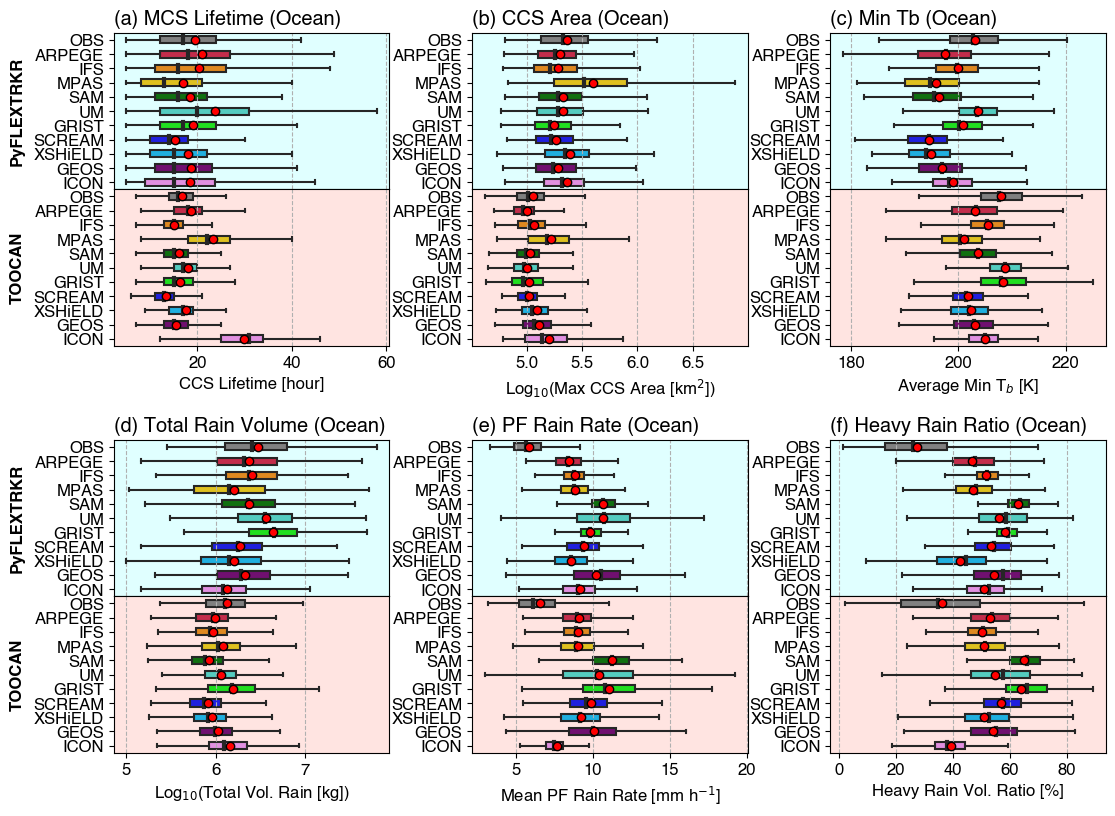

In [88]:
data_top = [
    [ccslifetime_pyflex_o, log10maxccsarea_pyflex_o, avgmintb_pyflex_o, ],
    [log10pfvolrain_pyflex_o, meanpfrainrate_pyflex_o, pfhrr_pyflex_o],
]
data_bot = [
    [ccslifetime_toocan_o, log10maxccsarea_toocan_o, avgmintb_toocan_o, ],
    [log10pfvolrain_toocan_o, meanpfrainrate_toocan_o, pfhrr_toocan_o],
]
titles = [
    ['(a) MCS Lifetime (Ocean)', '(b) CCS Area (Ocean)', '(c) Min Tb (Ocean)'],
    ['(d) Total Rain Volume (Ocean)', '(e) PF Rain Rate (Ocean)', '(f) Heavy Rain Ratio (Ocean)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Average Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'TOOCAN']
panel_colors = {'top':'lightcyan', 'bot':'mistyrose'}
legend_ncol = 2
figsize = [15,9]
fontsize = 12
figname = f'{figdir}boxwhisker_mcs_ocean_2x3_PyFLEXTRKR_TOOCAN.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

/tmp/ipykernel_1295742/913225336.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1295742/913225336.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1295742/913225336.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1295742/913225336.py:94: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykern

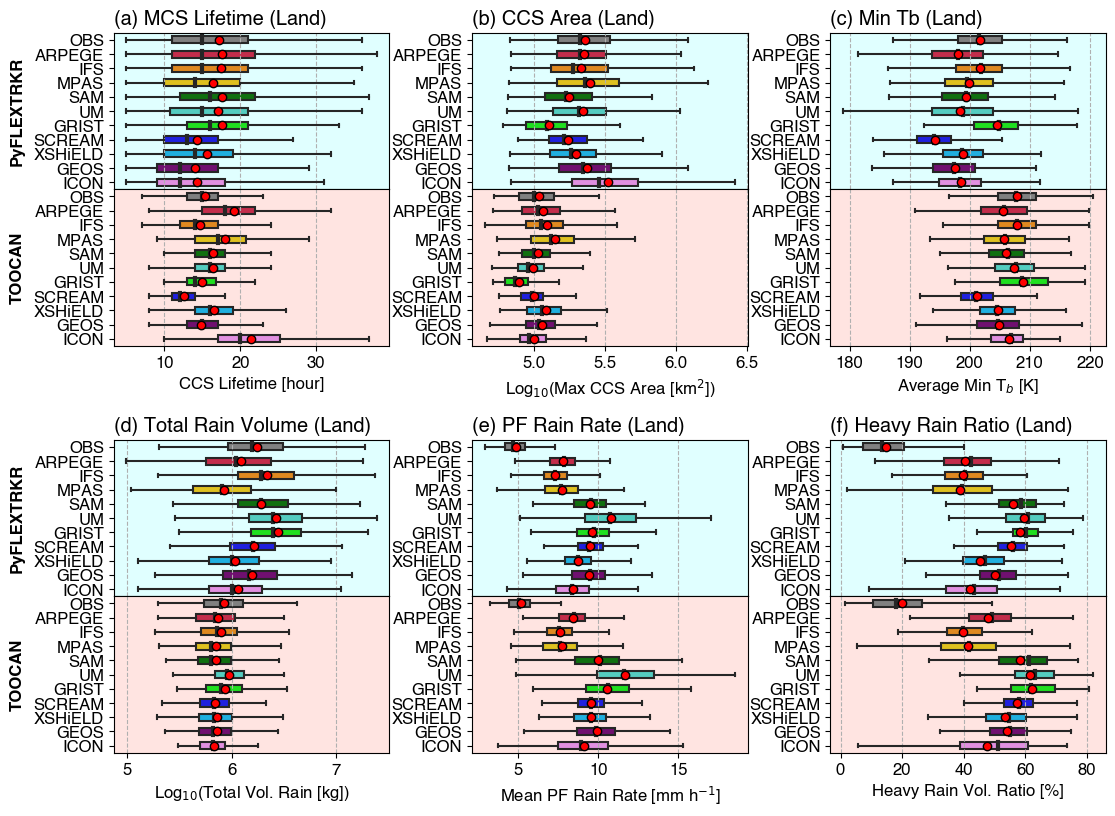

In [89]:
data_top = [
    [ccslifetime_pyflex_l, log10maxccsarea_pyflex_l, avgmintb_pyflex_l, ],
    [log10pfvolrain_pyflex_l, meanpfrainrate_pyflex_l, pfhrr_pyflex_l],
]
data_bot = [
    [ccslifetime_toocan_l, log10maxccsarea_toocan_l, avgmintb_toocan_l, ],
    [log10pfvolrain_toocan_l, meanpfrainrate_toocan_l, pfhrr_toocan_l],
]
titles = [
    ['(a) MCS Lifetime (Land)', '(b) CCS Area (Land)', '(c) Min Tb (Land)'],
    ['(d) Total Rain Volume (Land)', '(e) PF Rain Rate (Land)', '(f) Heavy Rain Ratio (Land)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Average Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'TOOCAN']
panel_colors = {'top':'lightcyan', 'bot':'mistyrose'}
legend_ncol = 2
figsize = [15,9]
fontsize = 12
figname = f'{figdir}boxwhisker_mcs_land_2x3_PyFLEXTRKR_TOOCAN.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

In [90]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/boxwhisker_mcs_land_2x3_PyFLEXTRKR_TOOCAN.png'